In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
import healpy as hp

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline
from plancklens.wigners import wigners
from plancklens import n0s

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)


In [2]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [4]:
# We define here the parameters for the profile of the cluster
M200, z = 2 * 1e14, 0.7
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180) #Physical size of the box in radian

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(lbox_amin, lbox_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 8000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 3000
ellmindat = 100

# Number of simulated maps 
nsims = 10

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/Users/sayan/Project_Geneva/git_repos/LensIt/lensit/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/npix1024_lpix_0.3amin_lmaxsky8000/M200_2.000000E+14_z0.7/10_sims


In [5]:
hprofile = profile.profile(results, profname)
xmax = hprofile.get_concentration(M200, z) # truncating at virial radius seems like at reasonable thing
lmax = ellmaxsky
R_200 = hprofile.get_r200(M200, z)
R_s = hprofile.get_rs(M200,z)
thtscale = hprofile.r_to_theta(z, R_s)
thtmax = hprofile.r_to_theta(z, R_200)
#thtmax = hprofile.x_to_theta_amin(M200, z, xmax)
#thtscale = hprofile.x_to_theta_amin(M200, z, 1.)

print('thmax in amin, thscale', thtmax, thtscale)
xg, wg = wigners.get_xgwg(np.cos(thtmax / 180 / 60 * np.pi),1., max(5000, int(lmax * thtmax / (360 * 60))))
kappa = hprofile.kappa_theta(M200, 1., np.arccos(xg) / np.pi * 180 * 60 )
kappa_ell = wigners.wignercoeff(kappa * wg, xg, 0, 0, lmax)
kappa0 = hprofile.get_kappa0(M200, z)

nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]
camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

N0s, N0s_curl = n0s.get_N0(beam_fwhm=1, nlev_t=nlev_t, nlev_p=nlev_t*np.sqrt(2), lmax_CMB=ellmaxdat, lmin_CMB=ellmindat, lmax_out=8000, cls_len=cls_unl_fid, cls_weight=cls_unl_fid)
Nl = N0s['ptt']

lmin = 100
lmax = 5000

npix = 1024  # Number of pixels
lpix_amin = 0.3

lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(lbox_amin, lbox_amin))
lbox_rad1 = (lbox_amin/60)*(np.pi/180)
libdir1 = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
clustermaps1 = lensingmap.cluster_maps(libdir1, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat,ellmin_data=ellmindat, cmb_exp=cmb_exp)

ell = np.arange(lmin, lmax+1)
int_fs = (2*ell +1)/4/np.pi

ell1, = np.where(clustermaps1.lib_skyalm.get_Nell()[:lmax+1] > 1)
for i in range(len(ell1)):
    if ell1[i] >= lmin:
        m = i
        break
ell1 = ell1[m:]
num_l_1 = clustermaps1.lib_skyalm.get_Nell()[ell1]

thmax in amin, thscale 2.139100514187885 0.6846534736764758
The size of the data patch is 307.2 X 307.2 arcmin central box


/Users/sayan/Project_Geneva/git_repos/LensIt/lensit/clusterlens/profile.py:279: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/sayan/Project_Geneva/git_repos/LensIt/lensit/clusterlens/profile.py:280: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


## If $\sum_l (2l+1)f_{sky} == \sum_l Num_l$

15892.0 15886.375338052267
the difference = 5.6


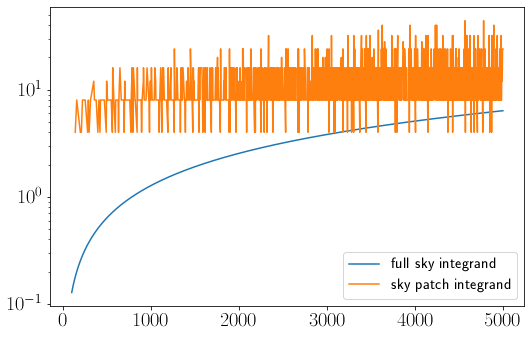

In [6]:
fsky = lbox_rad1**2/4/np.pi
integrand_fs =((2*ell +1)*fsky)#/ (lbox_rad1**2) *kappa_ell[ell]**2/(Nl[ell]*pp_to_kk(ell))
integrand_box = (num_l_1)#/ (lbox_rad1**2) *kappa_ell[ell1]**2/(Nl[ell1]*pp_to_kk(ell1))
plt.plot(ell, integrand_fs, label ="full sky integrand")
plt.plot(ell1, integrand_box, label="sky patch integrand")
plt.legend()
plt.yscale("log")
print(np.sum(integrand_box), np.sum(integrand_fs))
print("the difference = %0.1f"%(np.sum(integrand_box)-np.sum(integrand_fs)))

## If $\sum_l (2l+1)\frac{f_{sky}}{L^2} == \sum_l \frac{Num_l}{L^2}$

1990141.2397150658 1989436.8682261633
the difference = 704.4


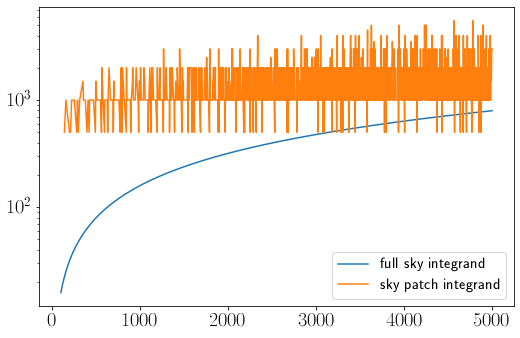

In [7]:
fsky = lbox_rad1**2/4/np.pi
integrand_fs =((2*ell +1)*fsky)/ (lbox_rad1**2) #*kappa_ell[ell]**2/(Nl[ell]*pp_to_kk(ell))
integrand_box = (num_l_1)/ (lbox_rad1**2) #*kappa_ell[ell1]**2/(Nl[ell1]*pp_to_kk(ell1))
plt.plot(ell, integrand_fs, label ="full sky integrand")
plt.plot(ell1, integrand_box, label="sky patch integrand")
plt.legend()
plt.yscale("log")
print(np.sum(integrand_box), np.sum(integrand_fs))
print("the difference = %0.1f"%(np.sum(integrand_box)-np.sum(integrand_fs)))

## If $\sum_l (2l+1)\frac{f_{sky}}{L^2}\frac{|\kappa^t_l|^2}{N_l} == \sum_l \frac{Num_l}{L^2}\frac{|\kappa^t_l|^2}{N_l}$

2.007513276799408 2.0104628965800444
the difference = -0.002950


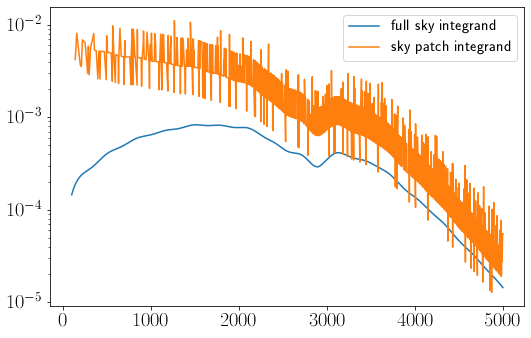

In [8]:
fsky = lbox_rad1**2/4/np.pi
integrand_fs =((2*ell +1)*fsky)/ (lbox_rad1**2) *(kappa_ell[ell]/kappa0)**2/(Nl[ell]*pp_to_kk(ell))
integrand_box = (num_l_1)/ (lbox_rad1**2) *(kappa_ell[ell1]/kappa0)**2/(Nl[ell1]*pp_to_kk(ell1))
plt.plot(ell, integrand_fs, label ="full sky integrand")
plt.plot(ell1, integrand_box, label="sky patch integrand")
plt.legend()
plt.yscale("log")
print(np.sum(integrand_box), np.sum(integrand_fs))
print("the difference = %f"%(np.sum(integrand_box)-np.sum(integrand_fs)))

In [9]:
print("full sky error =%f"%np.sqrt(1/np.sum(integrand_fs)))
print("box sky patch error =%f"%np.sqrt(1/np.sum(integrand_box)))

full sky error =0.705264
box sky patch error =0.705782
